In [44]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Import your dataset and transforms
from dataset_creater import *
from torchsummary import summary
from torchaudio import transforms as T

In [45]:
# Set the path to your dataset
data_folder = "./data"
# transform = T.MelSpectrogram(sample_rate=44100, n_mels=64)
transform = T.MFCC(sample_rate=44100, n_mfcc=32)

# Create an instance of your dataset
dataset = AudioDataset(data_folder, transform=transform, scale=(-625, 195))

# Define the sizes of your splits
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
# Move the training and validation data loaders to the selected device
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, shuffle=False)
test_loader = DataLoader(test_set, shuffle=False)


c:\Users\Sine\anaconda3\envs\pytorch\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [46]:
min_amplitude = np.inf
max_amplitude = -np.inf
for batch in train_loader:
    padded_waveforms, labels = batch
    # print("Padded waveforms shape:", padded_waveforms.shape)
    input_shape = padded_waveforms.shape[1:]
    if min_amplitude > padded_waveforms.min():
        min_amplitude = padded_waveforms.min()
    if max_amplitude < padded_waveforms.max():
        max_amplitude = padded_waveforms.max()
print(input_shape)
print("Min amplitude:", min_amplitude)
print("Max amplitude:", max_amplitude)

torch.Size([1, 32, 508])
Min amplitude: tensor(0.0004)
Max amplitude: tensor(1.0021)


In [47]:
class MelChordClassifier(nn.Module):
    def __init__(self):
        super(MelChordClassifier, self).__init__()
        # Define a CNN with input shape is (batch_size, 1, 128, 199) and output shape is (batch_size, 1)
        # it should reduce the dimensionality very quickly because the dataset is small (<1000)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(4,8), stride=1, padding=0) 
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4,8), stride=(2, 4)) 

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0) 
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=(2,4))

        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AdaptiveAvgPool2d((1,4))

        self.bn3 = nn.BatchNorm1d(64 * 1 * 4)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 1 * 4, 16)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(16, 1)
         # no activation function because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1) # flatten
        x = self.bn3(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # Use BCEWithLogitsLoss instead of BCELoss because it combines a Sigmoid layer and the BCELoss in one single class
        # the output shape should be (batch_size,)
        return x.view(-1)

In [48]:


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the selected device
model = MelChordClassifier().to(device)

# Instantiate loss function and move it to the selected device
criterion = nn.BCEWithLogitsLoss().to(device)

# Instantiate optimizer and move it to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# output summary of model
summary(model, input_shape)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 29, 501]           1,056
       BatchNorm2d-2          [-1, 32, 29, 501]              64
              ReLU-3          [-1, 32, 29, 501]               0
         MaxPool2d-4          [-1, 32, 13, 124]               0
            Conv2d-5          [-1, 64, 10, 121]          32,832
       BatchNorm2d-6          [-1, 64, 10, 121]             128
              ReLU-7          [-1, 64, 10, 121]               0
         MaxPool2d-8            [-1, 64, 4, 30]               0
            Conv2d-9            [-1, 64, 1, 27]          65,600
             ReLU-10            [-1, 64, 1, 27]               0
AdaptiveAvgPool2d-11             [-1, 64, 1, 4]               0
      BatchNorm1d-12                  [-1, 256]             512
          Dropout-13                  [-1, 256]               0
           Linear-14                   

100%|██████████| 22/22 [00:02<00:00,  7.60it/s]


Training - Epoch 1/50, Loss: 0.7135, Accuracy: 0.5691
Validation - Epoch 1/50, Loss: 0.7035, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  7.52it/s]


Training - Epoch 2/50, Loss: 0.6849, Accuracy: 0.5953
Validation - Epoch 2/50, Loss: 0.6937, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  7.50it/s]


Training - Epoch 3/50, Loss: 0.6613, Accuracy: 0.6084
Validation - Epoch 3/50, Loss: 0.6761, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  7.67it/s]


Training - Epoch 4/50, Loss: 0.6424, Accuracy: 0.6157
Validation - Epoch 4/50, Loss: 0.7131, Accuracy: 0.5412


100%|██████████| 22/22 [00:08<00:00,  2.54it/s]


Training - Epoch 5/50, Loss: 0.6506, Accuracy: 0.6012
Validation - Epoch 5/50, Loss: 0.7482, Accuracy: 0.5294


100%|██████████| 22/22 [00:10<00:00,  2.17it/s]


Training - Epoch 6/50, Loss: 0.6320, Accuracy: 0.6492
Validation - Epoch 6/50, Loss: 0.7079, Accuracy: 0.6353


100%|██████████| 22/22 [00:02<00:00,  8.05it/s]


Training - Epoch 7/50, Loss: 0.6336, Accuracy: 0.6259
Validation - Epoch 7/50, Loss: 0.6542, Accuracy: 0.5882


100%|██████████| 22/22 [00:02<00:00,  7.79it/s]


Training - Epoch 8/50, Loss: 0.6214, Accuracy: 0.6419
Validation - Epoch 8/50, Loss: 0.6279, Accuracy: 0.5294


100%|██████████| 22/22 [00:02<00:00,  7.73it/s]


Training - Epoch 9/50, Loss: 0.6010, Accuracy: 0.6652
Validation - Epoch 9/50, Loss: 0.6965, Accuracy: 0.6235


100%|██████████| 22/22 [00:02<00:00,  7.77it/s]


Training - Epoch 10/50, Loss: 0.6088, Accuracy: 0.6608
Validation - Epoch 10/50, Loss: 0.6503, Accuracy: 0.5765


100%|██████████| 22/22 [00:03<00:00,  7.27it/s]


Training - Epoch 11/50, Loss: 0.5813, Accuracy: 0.6870
Validation - Epoch 11/50, Loss: 0.8603, Accuracy: 0.5059


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Training - Epoch 12/50, Loss: 0.5715, Accuracy: 0.6812
Validation - Epoch 12/50, Loss: 0.8797, Accuracy: 0.5059


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


Training - Epoch 13/50, Loss: 0.5592, Accuracy: 0.7089
Validation - Epoch 13/50, Loss: 0.8785, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  7.41it/s]


Training - Epoch 14/50, Loss: 0.5506, Accuracy: 0.7089
Validation - Epoch 14/50, Loss: 0.6523, Accuracy: 0.6353


100%|██████████| 22/22 [00:02<00:00,  7.60it/s]


Training - Epoch 15/50, Loss: 0.5473, Accuracy: 0.7103
Validation - Epoch 15/50, Loss: 0.6159, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  7.60it/s]


Training - Epoch 16/50, Loss: 0.5229, Accuracy: 0.7220
Validation - Epoch 16/50, Loss: 0.6549, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  7.45it/s]


Training - Epoch 17/50, Loss: 0.5072, Accuracy: 0.7394
Validation - Epoch 17/50, Loss: 0.6275, Accuracy: 0.6471


100%|██████████| 22/22 [00:03<00:00,  6.34it/s]


Training - Epoch 18/50, Loss: 0.4912, Accuracy: 0.7496
Validation - Epoch 18/50, Loss: 0.7963, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  7.96it/s]


Training - Epoch 19/50, Loss: 0.4745, Accuracy: 0.7656
Validation - Epoch 19/50, Loss: 1.7904, Accuracy: 0.4824


100%|██████████| 22/22 [00:02<00:00,  7.39it/s]


Training - Epoch 20/50, Loss: 0.4665, Accuracy: 0.7846
Validation - Epoch 20/50, Loss: 0.7646, Accuracy: 0.6235


100%|██████████| 22/22 [00:03<00:00,  6.62it/s]


Training - Epoch 21/50, Loss: 0.4347, Accuracy: 0.8006
Validation - Epoch 21/50, Loss: 0.8920, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  7.84it/s]


Training - Epoch 22/50, Loss: 0.4219, Accuracy: 0.7962
Validation - Epoch 22/50, Loss: 0.5738, Accuracy: 0.6941


100%|██████████| 22/22 [00:02<00:00,  7.55it/s]


Training - Epoch 23/50, Loss: 0.4165, Accuracy: 0.8151
Validation - Epoch 23/50, Loss: 0.6016, Accuracy: 0.6824


100%|██████████| 22/22 [00:02<00:00,  7.53it/s]


Training - Epoch 24/50, Loss: 0.4251, Accuracy: 0.8151
Validation - Epoch 24/50, Loss: 2.1802, Accuracy: 0.4824


100%|██████████| 22/22 [00:03<00:00,  6.57it/s]


Training - Epoch 25/50, Loss: 0.3909, Accuracy: 0.8472
Validation - Epoch 25/50, Loss: 0.6071, Accuracy: 0.6235


100%|██████████| 22/22 [00:02<00:00,  7.87it/s]


Training - Epoch 26/50, Loss: 0.3786, Accuracy: 0.8457
Validation - Epoch 26/50, Loss: 1.7655, Accuracy: 0.4824


100%|██████████| 22/22 [00:02<00:00,  7.54it/s]


Training - Epoch 27/50, Loss: 0.3724, Accuracy: 0.8268
Validation - Epoch 27/50, Loss: 1.0451, Accuracy: 0.5294


100%|██████████| 22/22 [00:02<00:00,  7.46it/s]


Training - Epoch 28/50, Loss: 0.3493, Accuracy: 0.8515
Validation - Epoch 28/50, Loss: 0.6843, Accuracy: 0.5647


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Training - Epoch 29/50, Loss: 0.3390, Accuracy: 0.8675
Validation - Epoch 29/50, Loss: 0.6477, Accuracy: 0.5647


100%|██████████| 22/22 [00:02<00:00,  7.92it/s]


Training - Epoch 30/50, Loss: 0.3127, Accuracy: 0.8879
Validation - Epoch 30/50, Loss: 0.7592, Accuracy: 0.5294


100%|██████████| 22/22 [00:03<00:00,  6.67it/s]


Training - Epoch 31/50, Loss: 0.2888, Accuracy: 0.8937
Validation - Epoch 31/50, Loss: 1.5720, Accuracy: 0.5294


100%|██████████| 22/22 [00:02<00:00,  7.84it/s]


Training - Epoch 32/50, Loss: 0.2881, Accuracy: 0.8981
Validation - Epoch 32/50, Loss: 2.2933, Accuracy: 0.4824


100%|██████████| 22/22 [00:02<00:00,  7.47it/s]


Training - Epoch 33/50, Loss: 0.2686, Accuracy: 0.9054
Validation - Epoch 33/50, Loss: 0.6948, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  7.48it/s]


Training - Epoch 34/50, Loss: 0.2562, Accuracy: 0.9199
Validation - Epoch 34/50, Loss: 0.6833, Accuracy: 0.5765


100%|██████████| 22/22 [00:03<00:00,  6.58it/s]


Training - Epoch 35/50, Loss: 0.2400, Accuracy: 0.9258
Validation - Epoch 35/50, Loss: 0.5235, Accuracy: 0.7882


100%|██████████| 22/22 [00:02<00:00,  7.83it/s]


Training - Epoch 36/50, Loss: 0.2615, Accuracy: 0.9054
Validation - Epoch 36/50, Loss: 0.5345, Accuracy: 0.6824


100%|██████████| 22/22 [00:02<00:00,  7.54it/s]


Training - Epoch 37/50, Loss: 0.2186, Accuracy: 0.9476
Validation - Epoch 37/50, Loss: 0.5380, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  7.41it/s]


Training - Epoch 38/50, Loss: 0.2239, Accuracy: 0.9403
Validation - Epoch 38/50, Loss: 0.5671, Accuracy: 0.6353


100%|██████████| 22/22 [00:02<00:00,  7.51it/s]


Training - Epoch 39/50, Loss: 0.2040, Accuracy: 0.9476
Validation - Epoch 39/50, Loss: 0.6745, Accuracy: 0.5882


100%|██████████| 22/22 [00:03<00:00,  6.48it/s]


Training - Epoch 40/50, Loss: 0.1855, Accuracy: 0.9563
Validation - Epoch 40/50, Loss: 2.0599, Accuracy: 0.4824


100%|██████████| 22/22 [00:02<00:00,  7.82it/s]


Training - Epoch 41/50, Loss: 0.1809, Accuracy: 0.9709
Validation - Epoch 41/50, Loss: 0.5465, Accuracy: 0.7765


100%|██████████| 22/22 [00:02<00:00,  7.52it/s]


Training - Epoch 42/50, Loss: 0.1854, Accuracy: 0.9563
Validation - Epoch 42/50, Loss: 1.4876, Accuracy: 0.5176


100%|██████████| 22/22 [00:03<00:00,  6.26it/s]


Training - Epoch 43/50, Loss: 0.1826, Accuracy: 0.9578
Validation - Epoch 43/50, Loss: 1.7893, Accuracy: 0.4941


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


Training - Epoch 44/50, Loss: 0.1642, Accuracy: 0.9622
Validation - Epoch 44/50, Loss: 1.5550, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  7.50it/s]


Training - Epoch 45/50, Loss: 0.1632, Accuracy: 0.9665
Validation - Epoch 45/50, Loss: 2.3444, Accuracy: 0.4941


100%|██████████| 22/22 [00:02<00:00,  7.51it/s]


Training - Epoch 46/50, Loss: 0.1563, Accuracy: 0.9680
Validation - Epoch 46/50, Loss: 0.9029, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  7.44it/s]


Training - Epoch 47/50, Loss: 0.1393, Accuracy: 0.9767
Validation - Epoch 47/50, Loss: 0.5890, Accuracy: 0.7765


100%|██████████| 22/22 [00:02<00:00,  7.47it/s]


Training - Epoch 48/50, Loss: 0.1465, Accuracy: 0.9680
Validation - Epoch 48/50, Loss: 0.7389, Accuracy: 0.6824


100%|██████████| 22/22 [00:03<00:00,  7.28it/s]


Training - Epoch 49/50, Loss: 0.1270, Accuracy: 0.9913
Validation - Epoch 49/50, Loss: 0.4868, Accuracy: 0.7412


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Training - Epoch 50/50, Loss: 0.1252, Accuracy: 0.9898
Validation - Epoch 50/50, Loss: 2.2356, Accuracy: 0.5176
Testing - Accuracy: 0.5977


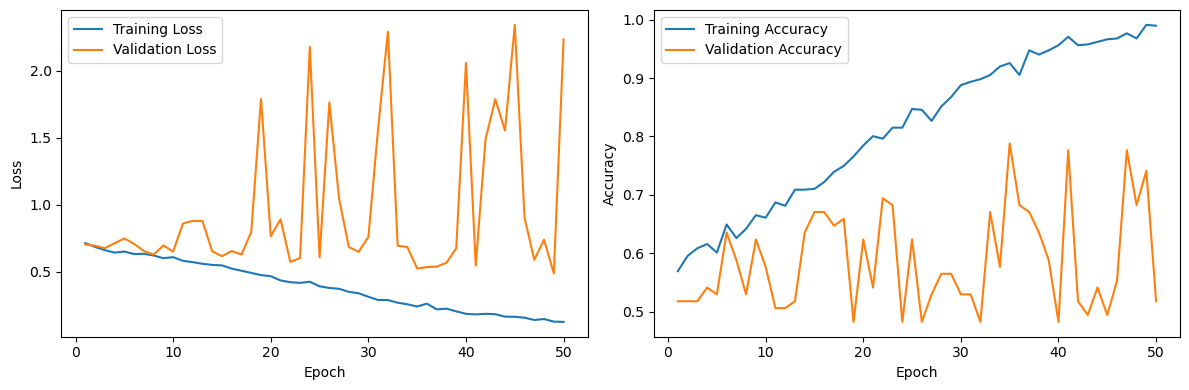

In [49]:
# Lists to store values for plotting
from cgi import test


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
        # convert labels to float because criterion requires float type labels
        labels = labels.type(torch.FloatTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs > 0.5
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.type(torch.FloatTensor)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs > 0.5
            val_correct += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_labels = test_labels.type(torch.FloatTensor)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5
        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Plot learning curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


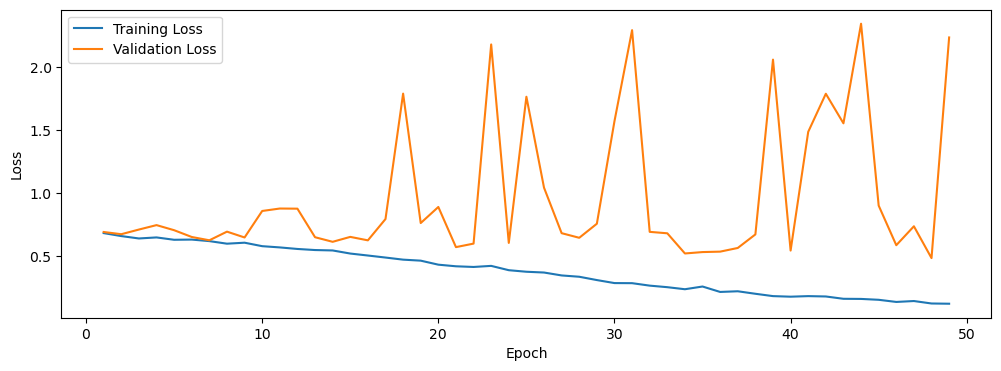

In [50]:
xrange = range(1, num_epochs)
plt.figure(figsize=(12, 4))
plt.plot(xrange, train_losses[1:], label='Training Loss')
plt.plot(xrange, val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing - Accuracy: 0.5977


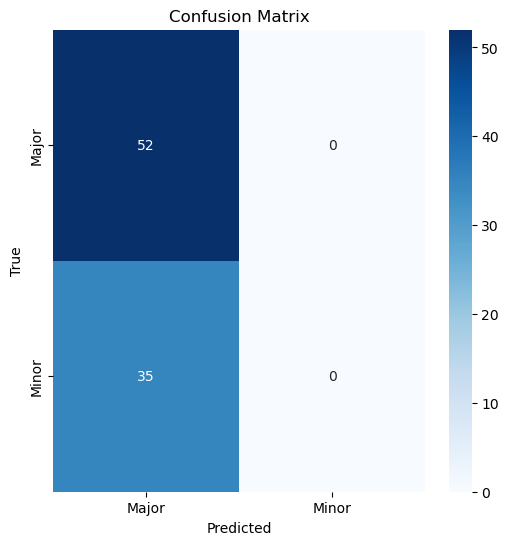

In [51]:
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Major', 'Minor']  # Modify based on your actual class names

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()